In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from community_simulator.usertools import (MakeConsumerDynamics, MakeResourceDynamics,  MakeParams,
                                           MakeMatrices, MakeInitialState, a_default)
from community_simulator import Community
from community_simulator.visualization import PlotTraj, StackPlot
import pickle
from biom import Table, load_table
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
%matplotlib inline

from torchdiffeq import odeint_adjoint as odeint
from torch_bnn import BNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [2]:
!ls

C.txt  neural-ode.ipynb  __pycache__	   split.ipynb
data   N.txt		 R.txt		   torch_bnn.py
D.txt  preprocess.ipynb  simple-sim.ipynb


In [3]:
C = pd.read_table('data/C.txt', index_col=[0, 1], header=[0, 1])
D = pd.read_table('data/D.txt', index_col=[0, 1], header=[0, 1])
N = pd.read_table('data/N.txt', index_col=[0, 1, 2], header=[0, 1])
R = pd.read_table('data/R.txt', index_col=[0, 1, 2], header=[0, 1])

In [4]:
wells = np.unique(N.index.get_level_values(0))
time = np.unique(N.reset_index()['time'])

n, r = N.shape[1], R.shape[1]
nr = n + r

idx = np.random.random(len(wells)) < 0.5
train_wells = wells[idx]
test_wells = wells[~idx]

In [5]:
class ODEFunc(nn.Module):

    def __init__(self, nr):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(nr, 10),
            nn.Tanh(),
            nn.Linear(10, nr),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0.1)
        self.y0 = nn.Parameter(torch.ones(nr), requires_grad=True).cuda()

    def forward(self, t, y):
        return self.net(y)


def loss_f(pred, data):
    # aitchison distance for error quantification
    loss__f = nn.MSELoss(reduction='mean')
    pred = F.softmax(pred)
    pred, data = torch.log(pred), torch.log(data + 1e-5)
    pred = pred - pred.mean(axis=1).view(-1, 1)
    data = data - data.mean(axis=1).view(-1, 1)
    err = loss__f(pred, data)
    #err = torch.sum((pred - data)**2, axis=1).mean()
    return err

In [6]:
# TODO: Build NN / BNN to draw function
# Figure out initial value
func = ODEFunc(nr).cuda()
t = torch.Tensor(time).cuda()

optimizer = optim.Adam(list(func.parameters()), lr=1e-2)

In [7]:
NRtraj = []
epochs = 5
train_loss, test_loss = [], []

for _ in tqdm.tqdm(range(epochs)):
    losses = []
    train_wells = np.random.permutation(train_wells)
    
    for i, w in enumerate(train_wells):
        # forward pass
        optimizer.zero_grad()
        idx = N.reset_index()['index'] == w
        sN = N.reset_index().loc[idx].set_index(['index', 'time', 'round'])
        sR = R.reset_index().loc[idx].set_index(['index', 'time', 'round'])
        data = torch.Tensor(np.hstack((sN.values, sR.values))).cuda()
        pred = odeint(func, func.y0, t)
        loss = loss_f(pred, data)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))
    
    losses = []
    for w in test_wells:
        with torch.no_grad():
            idx = N.reset_index()['index'] == w
            sN = N.reset_index().loc[idx].set_index(['index', 'time', 'round'])
            sR = R.reset_index().loc[idx].set_index(['index', 'time', 'round'])
            data = torch.Tensor(np.hstack((sN.values, sR.values))).cuda()
            pred = odeint(func, func.y0, t)
            loss = loss_f(pred, data)
            losses.append(loss.item())
    test_loss.append(np.mean(losses))

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-5-1db888750891>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred)
100%|██████████| 5/5 [01:22<00:00, 16.51s/it]


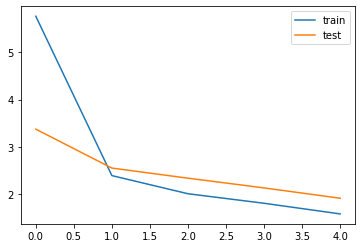

In [9]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

In [25]:
preds = []
w = test_wells[0]
with torch.no_grad():
    idx = N.reset_index()['index'] == w
    sN = N.reset_index().loc[idx].set_index(['index', 'time', 'round'])
    sR = R.reset_index().loc[idx].set_index(['index', 'time', 'round'])
    data = torch.Tensor(np.hstack((sN.values, sR.values))).cuda()
    pred = odeint(func, func.y0, t)
    pred = pred.detach().cpu().numpy()

In [35]:
pred = pd.DataFrame(pred, columns=pd.MultiIndex.from_tuples(list(sN.columns) + list(sR.columns)))

In [41]:
np.sum(pred < 0)

F0   S0     0
     S1     0
F1   S2     0
     S3     0
GEN  S4     0
           ..
T2   R85    0
     R86    0
     R87    0
     R88    0
     R89    0
Length: 95, dtype: int64

In [19]:
sN.shape, sR.shape

((50, 5), (50, 90))

In [22]:
preds.shape

(4600, 95)

In [21]:
func.y0.shape

torch.Size([95])

In [23]:
t.shape

torch.Size([50])

In [24]:
pred.shape

torch.Size([50, 95])

MultiIndex([('T0',  'R0'),
            ('T0',  'R1'),
            ('T0',  'R2'),
            ('T0',  'R3'),
            ('T0',  'R4'),
            ('T0',  'R5'),
            ('T0',  'R6'),
            ('T0',  'R7'),
            ('T0',  'R8'),
            ('T0',  'R9'),
            ('T0', 'R10'),
            ('T0', 'R11'),
            ('T0', 'R12'),
            ('T0', 'R13'),
            ('T0', 'R14'),
            ('T0', 'R15'),
            ('T0', 'R16'),
            ('T0', 'R17'),
            ('T0', 'R18'),
            ('T0', 'R19'),
            ('T0', 'R20'),
            ('T0', 'R21'),
            ('T0', 'R22'),
            ('T0', 'R23'),
            ('T0', 'R24'),
            ('T0', 'R25'),
            ('T0', 'R26'),
            ('T0', 'R27'),
            ('T0', 'R28'),
            ('T0', 'R29'),
            ('T1', 'R30'),
            ('T1', 'R31'),
            ('T1', 'R32'),
            ('T1', 'R33'),
            ('T1', 'R34'),
            ('T1', 'R35'),
            ('T1', 'R36'),
 